<a href="https://colab.research.google.com/github/simon-mellergaard/GAI-with-LLMs/blob/main/Project%20codes/Assignment04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4

> 1. *Fine-tune answerdotai/ModernBERT-large on the clinc_oos (load_dataset("clinc_oos", "plus")) dataset. Show the main training results and show the result from giving the model the following query: “Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in Paris and I need a 15 passenger van”.*
2. *Follow the example from Chapter 8 in Natural Language Processing with Transformers and produce a plot where you compare the accuracy, latency and size of 1) your fine tuned ModernBert-large baseline, 2) a distilled version, 3) a distilled version using Optuna and 4) a quantized-distilled version. Think carefully about the appropriate
student model to select.*

## Setup

In [1]:
# Installing packages
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.2 MB/s eta 0:00:00


In [2]:
# Loading libraries
import evaluate
import torch
import numpy as np
import os
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt

# Loading functions
from pathlib import Path
from time import perf_counter
from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import TrainingArguments
from transformers import Trainer
from transformers import AutoConfig
from google.colab import userdata
from huggingface_hub import login as login_hf
from wandb import login as login_wandb


In [3]:
# Logging in to Hugging Face and wandb
os.environ['HF_TOKEN'] = userdata.get('HF')
os.environ['WANDB_TOKEN'] = userdata.get('wandb')
os.environ['HF_USER'] = userdata.get('HF_USER')
login_hf(os.environ['HF_TOKEN'])
login_wandb(key = os.environ['WANDB_TOKEN'])

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.
/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: simonmellergaard (simonmellergaard-aarhus-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
# Setting up the device (GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

## 1 Fine-tuning ModernBERT

The [CLINC150](https://huggingface.co/datasets/clinc/clinc_oos) dataset is loaded. This dataset contains 150 different intents and corresponding queries, as well as one out-of-scope category, which is a total of 151 different labels:

In [7]:
from datasets import load_dataset

dataset_clinc = load_dataset("clinc_oos", "plus")

The [ModernBERT-large](https://huggingface.co/answerdotai/ModernBERT-large) model is loaded, and the tokenizer is defined.

In [6]:
# Tokenizing
model_id = "answerdotai/ModernBERT-large"
tokenizer = AutoTokenizer.from_pretrained(model_id)
def tokenize_function(batch):
    return tokenizer(batch["text"], truncation=True)
tokenized_datasets = dataset_clinc.map(tokenize_function,batched=True)

tokenized_datasets = tokenized_datasets.rename_column("intent", "label")

# Loading the base model
num_labels = len(set(tokenized_datasets["train"]["label"])) # 151
model = AutoModelForSequenceClassification.from_pretrained(
    model_id, num_labels=num_labels
).to(device)

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

Map:   0%|          | 0/15250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

Map:   0%|          | 0/5500 [00:00<?, ? examples/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


During training, the F1 and accuracy metrics are measured.

In [26]:
f1_score = evaluate.load("f1")
accuracy = evaluate.load("accuracy")

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    # Compute accuracy and F1 Score
    acc_result = accuracy.compute(references=labels, predictions=preds)
    acc = acc_result["accuracy"]

    f1_result = f1_score.compute(
        references=labels, predictions=preds, average="weighted"
    )
    f1 = f1_result["f1"]

    return {"accuracy": acc, "f1": f1}

The training arguments are defined below. It uses 4 epochs, and a lot of different variables. The validation set is used for evaluating during training.

In [8]:
training_args = TrainingArguments(
    "modernbert-clinc",
    # push_to_hub=True,
    per_device_train_batch_size=32,
    weight_decay=0.1,
    lr_scheduler_type="cosine",
    learning_rate=7e-5,
    num_train_epochs=6,
    eval_steps=150,
    logging_steps=150,
    eval_strategy="steps",
    # save_steps=150,
    # load_best_model_at_end=True,
    # metric_for_best_model="eval_loss",
    # greater_is_better=False,
)
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=tokenized_datasets["train"], # Using all training data
    eval_dataset=tokenized_datasets["validation"],
)

/tmp/ipykernel_76/1758788149.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [9]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


W0927 14:39:57.674000 76 torch/_inductor/utils.py:1137] [1/0] Not enough SMs to use max_autotune_gemm mode
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1
150,2.334400,0.583634,0.850645,0.844849
300,0.306700,0.373339,0.913871,0.911121
450,0.208900,0.246250,0.947419,0.947044
600,0.113200,0.239040,0.948710,0.948562
750,0.061800,0.218317,0.958710,0.958162
900,0.045600,0.198724,0.961613,0.961101
1050,0.037700,0.187051,0.965484,0.965038
1200,0.020400,0.168753,0.968387,0.968080
1350,0.009200,0.168061,0.969032,0.968700


W0927 14:41:37.286000 76 torch/_inductor/utils.py:1137] [1/2] Not enough SMs to use max_autotune_gemm mode
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings

TrainOutput(global_step=1434, training_loss=0.3291680724717251, metrics={'train_runtime': 1334.9001, 'train_samples_per_second': 68.544, 'train_steps_per_second': 1.074, 'total_flos': 4337518886342076.0, 'train_loss': 0.3291680724717251, 'epoch': 6.0})

In [10]:
trainer.push_to_hub()

Uploading...:   0%|          | 0.00/1.58G [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/simon-mellergaard/modernbert-clinc/commit/debd75d3988ee29f104f547d47be98ea895a2cd0', commit_message='End of training', commit_description='', oid='debd75d3988ee29f104f547d47be98ea895a2cd0', pr_url=None, repo_url=RepoUrl('https://huggingface.co/simon-mellergaard/modernbert-clinc', endpoint='https://huggingface.co', repo_type='model', repo_id='simon-mellergaard/modernbert-clinc'), pr_revision=None, pr_num=None)

/tmp/ipykernel_76/1636821701.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row], ignore_index=True)


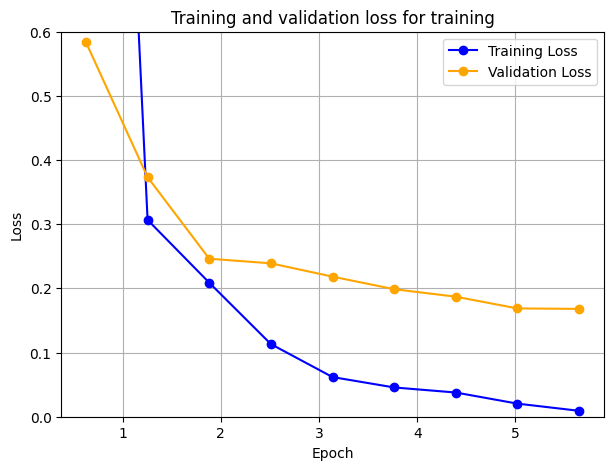

In [23]:
def plot_loss(trainer, title='Training and Validation Loss over Epochs'):
    # Creating dataframe for plotting. Load pandas and matplotlib
    history = trainer.state.log_history[:-1]
    results = pd.DataFrame(columns=pd.DataFrame(history).columns)
    # The results are stored in alternating order in the results, so it is
    # iterated through every second instance
    for i in range(len(history)):
        if i % 2 == 0:
            new_row = pd.DataFrame(history[i], index=[0])
            results = pd.concat([results, new_row], ignore_index=True)
        else:
            # The bottom most row is inserted the specific columns
            results.loc[len(results) - 1, history[i].keys()] = history[i]
    # Plotting the results
    plt.figure(figsize=(7, 5))
    plt.plot(results['epoch'], results['loss'], marker='o', label='Training Loss', color = 'blue')
    plt.plot(results['epoch'], results['eval_loss'], marker='o', label='Validation Loss', color = 'orange')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.ylim(0, 0.6) # Set y-axis limits from 0 to 1
    plt.show()
plot_loss(trainer, 'Training and validation loss for training')

A long comment on how good the model is. We can load it to do prediction:

In [24]:
# Loading the model
teacher_ckpt = "simon-mellergaard/modernbert-clinc"
pipe = pipeline("text-classification", model=teacher_ckpt)

Device set to use cuda:0


The model is now loaded, and can be evaluated based on the output:

In [10]:
query = "Hey, I'd like to rent a vehicle from Nov 1st to Nov 15th in Paris and I need a 15 passenger van"
pipe(query)

W0927 16:06:54.080000 403 torch/_inductor/utils.py:1436] [1/0_1] Not enough SMs to use max_autotune_gemm mode


[{'label': 'car_rental', 'score': 0.9998682737350464}]

The output looks pretty good or pretty bad.

## 2 Improving and comparing models

The following class is used to compare the models (taken from chapter 8 in NLP):

In [29]:
class PerformanceBenchmark:
    def __init__(self, pipeline, dataset, optim_type="ModernBERT baseline"):
        self.pipeline = pipeline
        self.dataset = dataset
        self.optim_type = optim_type

    def compute_accuracy(self):
        intents = dataset_clinc["test"].features["intent"]
        preds, labels = [], []
        for example in self.dataset:
            pred = self.pipeline(example["text"])[0]["label"]
            label = example["intent"]
            preds.append(intents.str2int(pred))
            labels.append(label)
        acc = accuracy.compute(predictions=preds, references=labels)
        print(f"Accuracy on test set - {acc['accuracy']:.3f}")
        return acc

    def compute_size(self):
        state_dict = self.pipeline.model.state_dict()
        tmp_path = Path("model.pt")
        torch.save(state_dict, tmp_path)
        # Calculate size in megabytes
        size_mb = Path(tmp_path).stat().st_size / (1024 * 1024)
        # Delete temporary file
        tmp_path.unlink()
        print(f"Model size (MB) - {size_mb:.2f}")
        return {"size_mb": size_mb}

    def time_pipeline(self):
        latencies = []
        # Warmup
        for _ in range(10):
            _ = self.pipeline(query)
        # Timed run
        for _ in range(100):
            start_time = perf_counter()
            _ = self.pipeline(query)
            latency = perf_counter() - start_time
            latencies.append(latency)
        # Compute run statistics
        time_avg_ms = 1000 * np.mean(latencies)
        time_std_ms = 1000 * np.std(latencies)
        print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")
        return {"time_avg_ms": time_avg_ms, "time_std_ms": time_std_ms}

    def run_benchmark(self):
        metrics = {}
        metrics[self.optim_type] = self.compute_size()
        metrics[self.optim_type].update(self.time_pipeline())
        metrics[self.optim_type].update(self.compute_accuracy())
        return metrics

<>:45: SyntaxWarning: invalid escape sequence '\-'
<>:45: SyntaxWarning: invalid escape sequence '\-'
/tmp/ipython-input-3135009958.py:45: SyntaxWarning: invalid escape sequence '\-'
  print(f"Average latency (ms) - {time_avg_ms:.2f} +\- {time_std_ms:.2f}")


This is used to compare the size, latency and accuracy of the different models. To start off, the baseline model with the fine-tuned ModernBert is calculated:

In [30]:
pb = PerformanceBenchmark(pipe, dataset_clinc["test"])
perf_metrics = pb.run_benchmark()

Model size (MB) - 1510.63
Average latency (ms) - 74.56 +\- 32.10
Accuracy on test set - 0.913


### Making a distilled version

This can reduce the size quite significantly, which is why it is a good idea. These two classes extends the training argument and trainer classes to make distilled models.

In [12]:
class DistillationTrainingArguments(TrainingArguments):
    def __init__(self, *args, alpha=0.5, temperature=2.0, **kwargs):
        super().__init__(*args, **kwargs)
        self.alpha = alpha
        self.temperature = temperature

class DistillationTrainer(Trainer):
    def __init__(self, *args, teacher_model=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.teacher_model = teacher_model

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        inputs = inputs.to(device)
        outputs_stu = model(**inputs)
        # Extract cross-entropy loss and logits from student
        loss_ce = outputs_stu.loss
        logits_stu = outputs_stu.logits
        # Extract logits from teacher
        with torch.no_grad():
            outputs_tea = self.teacher_model(**inputs)
            logits_tea = outputs_tea.logits
        # Soften probabilities and compute distillation loss
        loss_fct = nn.KLDivLoss(reduction="batchmean")
        loss_kd = self.args.temperature ** 2 * loss_fct(
            F.log_softmax(logits_stu / self.args.temperature, dim=-1),
            F.softmax(logits_tea / self.args.temperature, dim=-1))
        # Return weighted student loss
        loss = self.args.alpha * loss_ce + (1. - self.args.alpha) * loss_kd
        return (loss, outputs_stu) if return_outputs else loss

To make a distilled version of the fine-tuned model, a student model needs to be specified. For a student model to work well, it should have the same model type as the teacher. As the teacher is the ModernBERT-large model, the [ModernBERT-base](https://huggingface.co/answerdotai/ModernBERT-base) model can be used as a student, as these are of the same type, but with the base-model having fewer parameters and layers.

In [17]:
student_ckpt = "answerdotai/ModernBERT-base"
student_tokenizer = AutoTokenizer.from_pretrained(student_ckpt)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = dataset_clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "label")

Map:   0%|          | 0/3100 [00:00<?, ? examples/s]

In [14]:
id2label = pipe.model.config.id2label
label2id = pipe.model.config.label2id

In [16]:
student_config = (AutoConfig
                  .from_pretrained(student_ckpt, num_labels=num_labels,
                                   id2label=id2label, label2id=label2id))

def student_init():
    return (AutoModelForSequenceClassification
            .from_pretrained(student_ckpt, config=student_config).to(device))

In [18]:
teacher_model = (AutoModelForSequenceClassification
                 .from_pretrained(teacher_ckpt, num_labels=num_labels)
                 .to(device))

In [19]:
def compute_metrics(pred):
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

batch_size = 48

student_training_args = DistillationTrainingArguments(
    push_to_hub=True,
    output_dir="modernbert-base-distiled-clinc",
    eval_strategy = "epoch",
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    alpha=1,
    weight_decay=0.01,
)

In [20]:
modernbert_trainer = DistillationTrainer(
    model_init=student_init,
    teacher_model=teacher_model,
    args=student_training_args,
    train_dataset=clinc_enc['train'],
    eval_dataset=clinc_enc['validation'],
    compute_metrics=compute_metrics,
    tokenizer=student_tokenizer)

/tmp/ipython-input-3271489460.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DistillationTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)


model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
modernbert_trainer.train()
modernbert_trainer.push_to_hub()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': None, 'bos_token_id': None}.
Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.466414,0.889677
2,1.241500,0.277781,0.930645
3,1.241500,0.220483,0.946774
4,0.056000,0.211912,0.949677
5,0.006100,0.212025,0.948065


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...d-clinc/training_args.bin: 100%|##########| 5.84kB / 5.84kB            

  ...d-clinc/model.safetensors:   7%|6         | 41.8MB /  599MB            

  ...989288.bbe956cb5fcc.403.0: 100%|##########| 15.8kB / 15.8kB            

CommitInfo(commit_url='https://huggingface.co/simon-mellergaard/modernbert-base-distiled-clinc/commit/0c3a582db8b542d63377488caf2ca96321432db6', commit_message='End of training', commit_description='', oid='0c3a582db8b542d63377488caf2ca96321432db6', pr_url=None, repo_url=RepoUrl('https://huggingface.co/simon-mellergaard/modernbert-base-distiled-clinc', endpoint='https://huggingface.co', repo_type='model', repo_id='simon-mellergaard/modernbert-base-distiled-clinc'), pr_revision=None, pr_num=None)

In [ ]:
modernbert_trainer.push_to_hub()

In [31]:
finetuned_ckpt = "simon-mellergaard/modernbert-base-distiled-clinc"
pipe = pipeline("text-classification", model=finetuned_ckpt)

Device set to use cuda:0


In [23]:
pipe(query)

[{'label': 'car_rental', 'score': 0.9958439469337463}]

In [32]:
pb = PerformanceBenchmark(pipe, dataset_clinc["test"], optim_type='ModernBERT-base-distiled')
perf_metrics.update(pb.run_benchmark())

Model size (MB) - 571.19
Average latency (ms) - 27.66 +\- 2.67
Accuracy on test set - 0.884


The model became a lot smaller (1.5GB to 0.57GB), as well as faster. The test accuracy is a bit lower however.

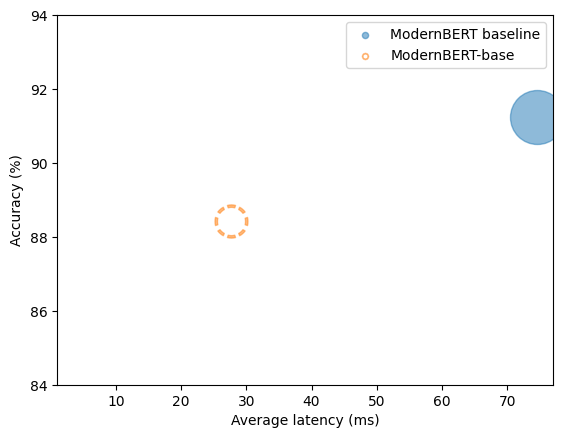

In [39]:
def plot_metrics(perf_metrics, current_optim_type=""):
    df = pd.DataFrame.from_dict(perf_metrics, orient='index')

    for idx in df.index:
        df_opt = df.loc[idx]
        # Add a dashed circle around the current optimization type
        if idx == current_optim_type:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        alpha=0.5, s=df_opt["size_mb"], label=idx,
                        marker='$\u25CC$')
        else:
            plt.scatter(df_opt["time_avg_ms"], df_opt["accuracy"] * 100,
                        s=df_opt["size_mb"], label=idx, alpha=0.5)

    legend = plt.legend(bbox_to_anchor=(1,1))
    for handle in legend.legend_handles:
        handle.set_sizes([20])

    plt.ylim(84,94)
    # Use the slowest model to define the x-axis range
    xlim = int(perf_metrics["ModernBERT baseline"]["time_avg_ms"] + 3)
    plt.xlim(1, xlim)
    plt.ylabel("Accuracy (%)")
    plt.xlabel("Average latency (ms)")
    plt.show()

plot_metrics(perf_metrics)

In [40]:
perf_metrics

{'ModernBERT baseline': {'size_mb': 1510.626826286316,
  'time_avg_ms': np.float64(74.55708581999488),
  'time_std_ms': np.float64(32.0965104584705),
  'accuracy': 0.9125454545454545},
 'ModernBERT-base': {'size_mb': 571.1876935958862,
  'time_avg_ms': np.float64(27.662510329992074),
  'time_std_ms': np.float64(2.6652236648091097),
  'accuracy': 0.8843636363636364}}

### Distiled version with optuna

With this model, the model is tuned with optuna, to utilize bayesian optimization.

### Distiled version with quantization

Quantization is now used to further improve size and performance.